## Introduction

In this notebook we will try to derermine what determines best red wine quality. Dataset can be found here [Kaggle: Red Wine Quality](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009).

We will use TensorFlow 2.0 to train DL model and predict wine quality and compare models performance with RandomForestClasifier model.

## The usual suspects

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn import metrics
%matplotlib inline

In [18]:
df = pd.read_csv('winequality-red.csv', low_memory=False)

## EDA

Inspect and analyse imported data

In [19]:
df.head().T

,0,1,2,3,4
fixed acidity,7.4000,7.8000,7.800,11.200,7.4000
volatile acidity,0.7000,0.8800,0.760,0.280,0.7000
citric acid,0.0000,0.0000,0.040,0.560,0.0000
residual sugar,1.9000,2.6000,2.300,1.900,1.9000
chlorides,0.0760,0.0980,0.092,0.075,0.0760
free sulfur dioxide,11.0000,25.0000,15.000,17.000,11.0000
total sulfur dioxide,34.0000,67.0000,54.000,60.000,34.0000
density,0.9978,0.9968,0.997,0.998,0.9978
pH,3.5100,3.2000,3.260,3.160,3.5100
sulphates,0.5600,0.6800,0.650,0.580,0.5600


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


### What determines wine quality?

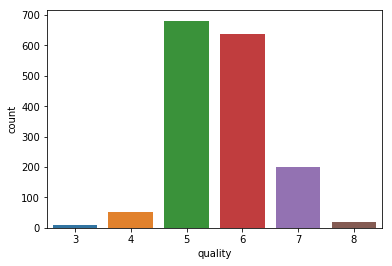

In [221]:
sns.countplot(x='quality', data=df);

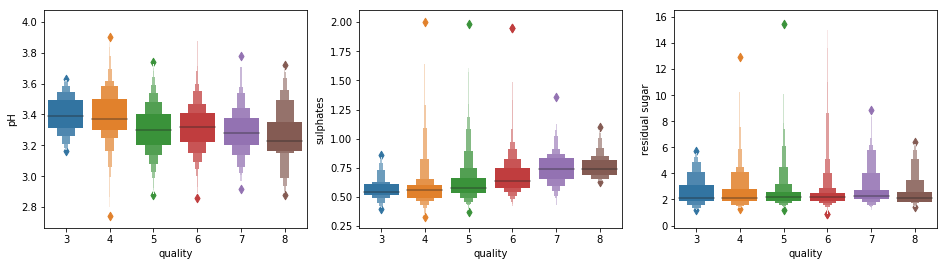

In [219]:
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(16)
sns.boxenplot(x='quality', y='pH', data=df, ax=axs[0])
sns.boxenplot(x='quality', y='sulphates', data=df, ax=axs[1])
sns.boxenplot(x='quality', y='residual sugar', data=df, ax=axs[2]);

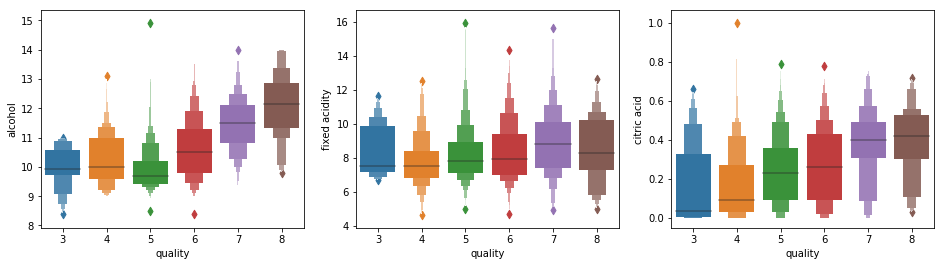

In [220]:
fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(16)
sns.boxenplot(x='quality', y='alcohol', data=df, ax=axs[0])
sns.boxenplot(x='quality', y='fixed acidity', data=df, ax=axs[1])
sns.boxenplot(x='quality', y='citric acid', data=df, ax=axs[2]);

Seems like more **alcohol** makes for better wine. Who knew?! :D

While `fixed acidity` or `residual sugar` does not seem to affect quality at all

## Data preprocessing

Select feature columns to use them later

In [43]:
features = df.columns.to_list()
features.remove('quality')

In [45]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('quality', axis=1))
df_features = pd.DataFrame(scaled_features, columns=feat_columns)

In [47]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,3.435512e-16,1.000313,-2.137045,-0.700719,-0.241094,0.505795,4.355149
volatile acidity,1599.0,1.699704e-16,1.000313,-2.278280,-0.769931,-0.043689,0.626688,5.877976
citric acid,1599.0,4.335355e-16,1.000313,-1.391472,-0.929318,-0.056360,0.765247,3.743574
residual sugar,1599.0,-1.905223e-16,1.000313,-1.162696,-0.453218,-0.240375,0.043416,9.195681
chlorides,1599.0,4.838739e-16,1.000313,-1.603945,-0.371229,-0.179946,0.053845,11.127035
free sulfur dioxide,1599.0,1.432042e-16,1.000313,-1.422500,-0.848716,-0.179300,0.490115,5.367284
total sulfur dioxide,1599.0,1.289532e-16,1.000313,-1.230584,-0.744040,-0.257497,0.472318,7.375154
density,1599.0,-3.482795e-14,1.000313,-3.538731,-0.607756,0.001760,0.576825,3.680055
pH,1599.0,3.002879e-15,1.000313,-3.700401,-0.655141,-0.007213,0.575922,4.528282
sulphates,1599.0,7.639596e-16,1.000313,-1.936507,-0.638220,-0.225128,0.424016,7.918677


## Modeling

### Prepare train, validation and test datasets

In [51]:
train_data, test_data, train_labels, test_labels = train_test_split(df_features, df['quality'], test_size=0.4)
val_data, test_data, val_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5)

Sanity check for data

In [52]:
[x.shape for x in [train_data, train_labels, val_data, val_labels, test_data, test_labels]]

[(959, 11), (959,), (320, 11), (320,), (320, 11), (320,)]

### Build model

In [430]:
def build_model(n_layers, layer_size, n_classes, final_activation, input_shape):
    layers = [tf.keras.layers.BatchNormalization(input_shape=input_shape)]
    for _ in range(n_layers):
        layers.extend([
            tf.keras.layers.Dense(layer_size, kernel_initializer='he_uniform'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(),
        ])
    layers.append(tf.keras.layers.Dense(n_classes, activation=final_activation))
    
    seq_model = tf.keras.Sequential(layers)

    seq_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(lr=1e-3),
        loss=tf.keras.losses.mean_squared_error,
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.mean_absolute_error,
        ]
    )
    
    return seq_model

In [431]:
model = build_model(
    n_layers=3,
    layer_size=64,
    n_classes=1,
    final_activation='relu',
    input_shape=train_data.values.shape[1:]
)

In [432]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_128 (Bat (None, 11)                44        
_________________________________________________________________
dense_128 (Dense)            (None, 64)                768       
_________________________________________________________________
leaky_re_lu_96 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
batch_normalization_129 (Bat (None, 64)                256       
_________________________________________________________________
dense_129 (Dense)            (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
batch_normalization_130 (Bat (None, 64)              

### Initial training

In [433]:
history = model.fit(
    x=train_data.values,
    y=train_labels.values,
    validation_data=(val_data.values, val_labels.values),
    batch_size=64,
    epochs=200,
    shuffle=True,
    verbose=0
)

In [434]:
model.evaluate(train_data, train_labels)

959/959 [==============================] - 0s 220us/sample - loss: 0.1471 - root_mean_squared_error: 0.3835 - mean_absolute_error: 0.2974


[0.14707203842582992, 0.3834997, 0.29740414]

## Model evaluation

In [435]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    fig, axs = plt.subplots(ncols=2)
    fig.set_figwidth(16)
    
    sns.lineplot(x='epoch', y='mean_absolute_error', data=hist, ax=axs[0])
    ax1 = sns.lineplot(x='epoch', y='val_mean_absolute_error', data=hist, ax=axs[0])
    ax1.set(xlabel='Epoch', ylabel='MAE')
    ax1.legend(labels=['Train Error','Val Error'])
    ax1_twinx = ax1.twinx()
    ax1_twinx1 = sns.lineplot(x='epoch', y='loss', data=hist, ax=ax1_twinx, color='red')
    ax1_twinx1.set(ylabel='Loss')
    
    sns.lineplot(x='epoch', y='root_mean_squared_error', data=hist, ax=axs[1])
    ax2 = sns.lineplot(x='epoch', y='val_root_mean_squared_error', data=hist, ax=axs[1])
    ax2.set(xlabel='Epoch', ylabel='MAE')
    ax2.legend(labels=['Train Error','Val Error'])
    ax2_twinx = ax2.twinx()
    ax2_twinx1 = sns.lineplot(x='epoch', y='loss', data=hist, ax=ax2_twinx, color='red')
    ax2_twinx1.set(ylabel='Loss')

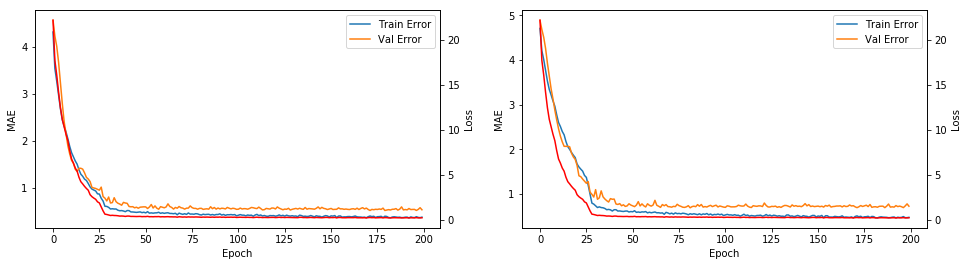

In [436]:
plot_history(history)

Graph indicates, that error is not improving much after a while. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve.

First rebuild model and add callback for early stop.

_NB! Loss is RED line._

In [437]:
model = build_model(
    n_layers=3,
    layer_size=64,
    n_classes=1,
    final_activation='relu',
    input_shape=train_data.values.shape[1:]
)

In [438]:
history = model.fit(
    x=train_data.values,
    y=train_labels.values,
    validation_data=(val_data.values, val_labels.values),
    batch_size=64,
    epochs=200,
    shuffle=True,
    verbose=0,
    callbacks = [
         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
    ]
)

Save and load model just to be safe after final training.

In [440]:
model.save('model_dump.h5')

In [442]:
model = tf.keras.models.load_model('model_dump.h5')

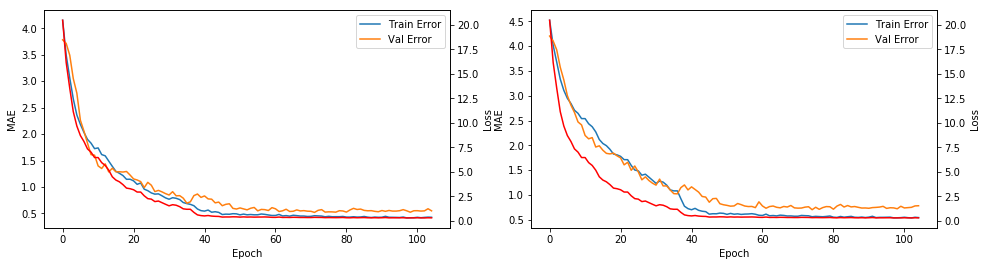

In [443]:
plot_history(history)

And here we saved some procesing time by stopping learning early.

_NB! Loss is RED line._

In [444]:
model.evaluate(train_data, train_labels)

959/959 [==============================] - 0s 187us/sample - loss: 0.2276 - root_mean_squared_error: 0.4770 - mean_absolute_error: 0.3698


[0.22756396577430343, 0.47703665, 0.36979496]

### Make predictions

In [445]:
test_predictions = model.predict(test_data).flatten()

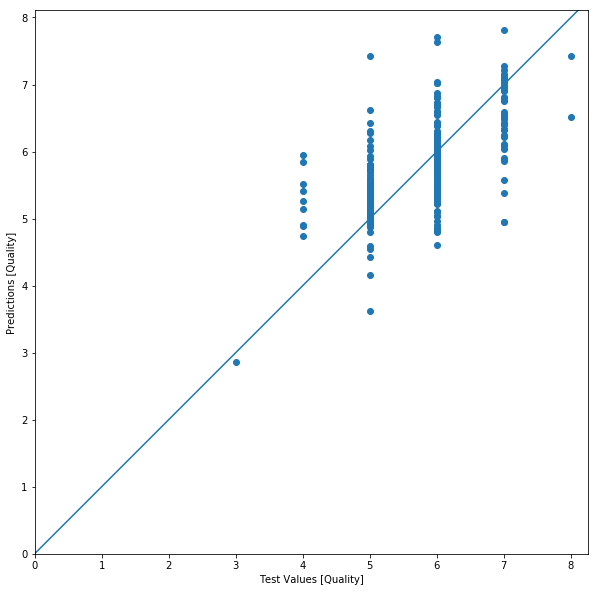

In [446]:
plt.figure(figsize=(20,10));
plt.scatter(test_labels, test_predictions)
plt.xlabel('Test Values [Quality]')
plt.ylabel('Predictions [Quality]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100]);

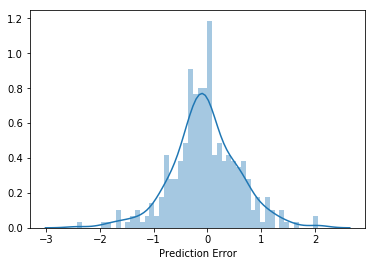

In [447]:
sns.distplot(
    (test_labels-test_predictions),
    bins=50,
    axlabel="Prediction Error"
);

## Compare with RandomForestRegressor

Prepare data for RandomForestRegressor

In [167]:
train_data_cv = pd.concat([train_data, val_data], axis=0)
train_labels_cv = pd.concat([train_labels, val_labels], axis=0)

In [192]:
rfc_gs = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        "n_estimators": np.linspace(10, 500, 3).astype(int),
        "min_samples_leaf": np.linspace(1, 10, 3).astype(int),
        "max_depth": np.linspace(10, 100, 3).astype(int),
        "max_features": ['sqrt', 'log2', 0.1],
    },
    n_jobs=-1,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)

In [193]:
rfc_gs.fit(train_data_cv, train_labels_cv)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   25.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': array([ 10,  55, 100

In [198]:
predictions_rf = rfc_gs.predict(test_data)

In [199]:
print('MAE:', metrics.mean_absolute_error(test_labels, predictions_rf))
print('MSE:', metrics.mean_squared_error(test_labels, predictions_rf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_labels, predictions_rf)))

MAE: 0.38976249999999996
MSE: 0.27407645
RMSE: 0.5235231131478342


## Conclusion

In [429]:
conclusions = pd.DataFrame(
    [[0.21963657014561397, 0.46318796, 0.36840096],[0.27407645, 0.5235231131478342, 0.38976249999999996]], 
    index=['DL', 'RFR'],
    columns= ['MSE', 'RMSE', 'MAE']
)
conclusions

,MSE,RMSE,MAE
DL,0.219637,0.463188,0.368401
RFR,0.274076,0.523523,0.389762


Only with some tinkering with hyper parameters we already see that DL model performs better than Random Forest.